In [17]:
onColab = True
model_path = './inno_training_no_smooth_final'

# Decide batch size and validation split
batch_size = 128
validation_split = 0.2
epochs = 140

dataset_path = './Training.csv'

window = 600
stride = 10
# 864 / 8
telescope = 108

## Init
Initialize codalab, libraries and seed

In [18]:
#@title connect to codalab
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE2


In [19]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [20]:
#@title init seed everywhere
seed = 43

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset import and manipulation

In [21]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.describe()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000
mean,6.094102,4.695539,13.337485,2.448660,2.407010,23.237929,8.231283
std,1.941639,3.374224,11.703203,3.001798,0.994063,14.298260,11.285101
min,-0.972080,-8.450380,-37.581721,-9.028060,-1.275860,-6.006860,-42.769221
25%,4.791440,2.223420,10.672820,0.468800,2.112200,12.560240,6.604160
50%,5.702780,4.668600,15.676059,2.533840,2.618500,20.151420,10.968300
75%,7.067300,7.115440,20.568080,4.656980,3.021880,31.245199,15.334100
max,15.106680,18.122899,41.138801,14.035980,6.056360,77.371620,31.024420


In [22]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
# inspect_dataframe(dataset, dataset.columns)

In [23]:
def normalize(dataset, t=None):
  if t is None or t == 'minmax':
    x_min = dataset.min(axis=0)
    print(x_min.shape)
    x_max = dataset.max()
    nd = (dataset - x_min) / (x_max - x_min)
    return nd
  elif t == 'mean_std':
    x_mean = dataset.mean()
    x_std = dataset.std()
    nd = (dataset - x_mean) / x_std
    return nd

In [24]:
normalized_ds = normalize(dataset)
normalized_ds.describe()

(7,)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000
mean,0.439473,0.494704,0.646835,0.497602,0.502286,0.350747,0.691123
std,0.120758,0.126978,0.148668,0.130151,0.135575,0.171486,0.152928
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.358455,0.401674,0.612986,0.411760,0.462078,0.222685,0.669074
50%,0.415135,0.493691,0.676543,0.501296,0.531130,0.313729,0.728213
75%,0.500000,0.585770,0.738687,0.593350,0.586144,0.446783,0.787376
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
import math
def chunk(dataset, window, telescope, stride):
  """
  divide the dataset in chunks. 
  It keeps the right-most elements and discard the left ones, if size and stride are not compatible with dimensions. 
  """
  size = window + telescope
  X = []
  Y = []
  for i in range(len(dataset) - size, -1, -stride):
    
    count = 0
    prev = 0
    for ds in dataset.filter(range(i, i + size), axis=0)['Crunchiness']:
      if math.isclose(prev, ds, rel_tol=1e-7):
        count += 1
        if count > 40: break
      else: 
        count = 0
      prev = ds

    if count < 40:
      X.append(dataset[i: i + window])
      Y.append(dataset[i + window: i + size])
  X.reverse()
  Y.reverse()
  return (np.array(X), np.array(Y))

In [27]:
x, y = chunk(normalized_ds, window, telescope, stride)
x.shape, y.shape

((5683, 600, 7), (5683, 108, 7))

In [28]:
x.shape, y.shape

((5683, 600, 7), (5683, 108, 7))

In [29]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

In [30]:
# shuffle data so that 
x, y = sklearn.utils.shuffle(x, y, random_state=seed)
x.shape, y.shape

((5683, 600, 7), (5683, 108, 7))

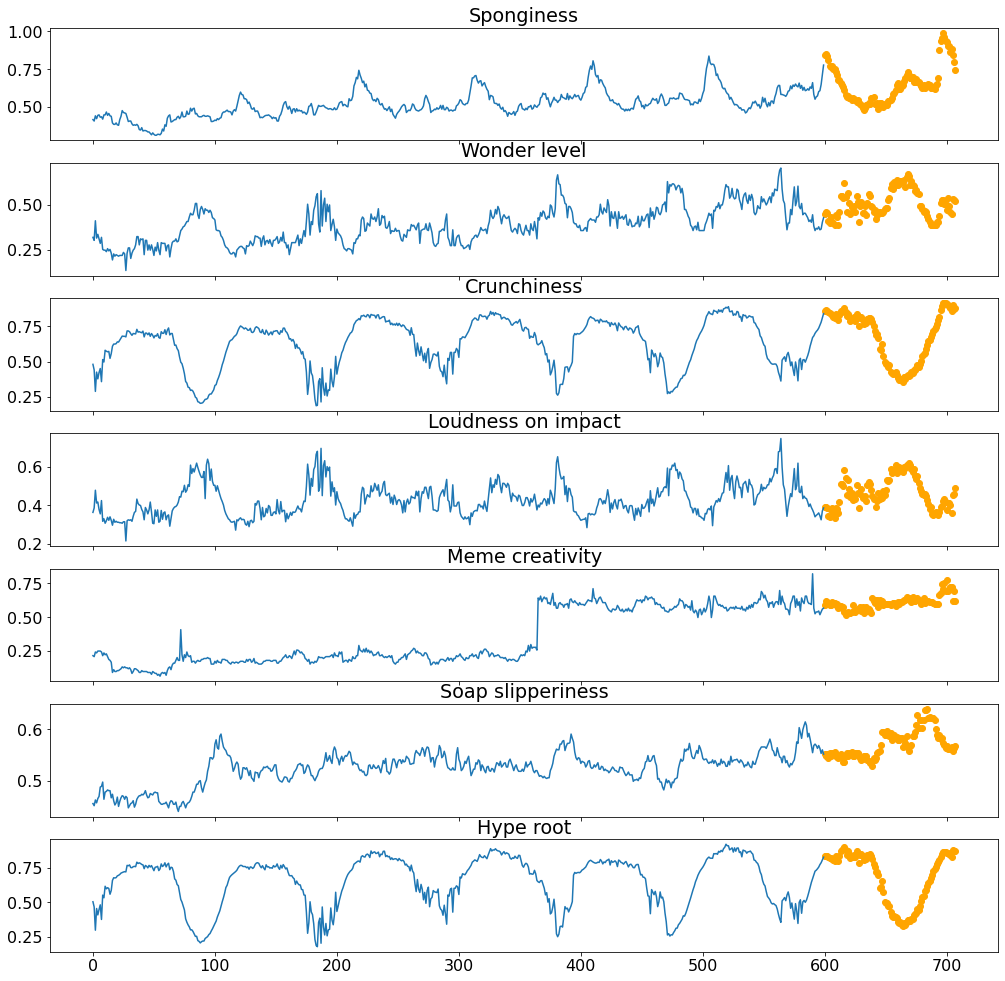

In [31]:
inspect_multivariate(x, y, dataset.columns, telescope)

## Model
build the model and learn

In [32]:
input_shape = (window, 7)
output_shape = (telescope, 7)

In [33]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]

    #
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))    
    # conv = tfkl.Conv1D(512, 3, padding='same', activation='relu')
    encoder_l1 = tf.keras.layers.LSTM(700, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

    #
    decoder_l1 = tf.keras.layers.LSTM(700, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    #
    model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_e1d1.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e1d1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 7)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 700),        1982400     ['input_1[0][0]']                
                                 (None, 700),                                                     
                                 (None, 700)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 108, 700)     0           ['lstm[0][0]']                   
                                                                                              

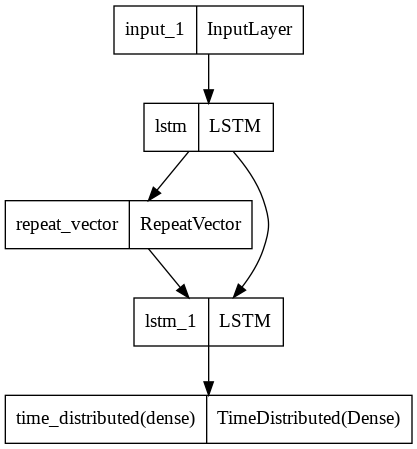

In [34]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [35]:
# def schedule(ind, rate):
#   if ind == 0: return rate 
#   if ind % 8 == 0:
#     return rate * 3 / 4
#   return rate

# Train the model
history = model.fit(
    x = x,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        # tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0),
        # tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/140
36/36 [==============================] - 46s 1s/step - loss: 0.0344 - mae: 0.1321 - val_loss: 0.0130 - val_mae: 0.0822 - lr: 0.0010
Epoch 2/140
36/36 [==============================] - 38s 1s/step - loss: 0.0118 - mae: 0.0777 - val_loss: 0.0117 - val_mae: 0.0758 - lr: 0.0010
Epoch 3/140
36/36 [==============================] - 39s 1s/step - loss: 0.0111 - mae: 0.0747 - val_loss: 0.0113 - val_mae: 0.0737 - lr: 0.0010
Epoch 4/140
36/36 [==============================] - 38s 1s/step - loss: 0.0108 - mae: 0.0736 - val_loss: 0.0111 - val_mae: 0.0731 - lr: 0.0010
Epoch 5/140
36/36 [==============================] - 38s 1s/step - loss: 0.0106 - mae: 0.0727 - val_loss: 0.0108 - val_mae: 0.0729 - lr: 0.0010
Epoch 6/140
36/36 [==============================] - 38s 1s/step - loss: 0.0104 - mae: 0.0723 - val_loss: 0.0108 - val_mae: 0.0747 - lr: 0.0010
Epoch 7/140
36/36 [==============================] - 38s 1s/step - loss: 0.0104 - mae: 0.0722 - val_loss: 0.0107 - val_mae: 0.0733 - lr:

In [36]:
model.save(model_path)

In [37]:
model = tfk.models.load_model(model_path)

## Analytics
Here we compute some analytics (just to get a very rough idea: there is no test set, thus these analytics are not so good!)

In [38]:
X = x[100:200]
Y = y[100:200]
predictions = model.predict(X)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(Y.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(Y.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(100, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0030192225>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.037884057>)

In [39]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

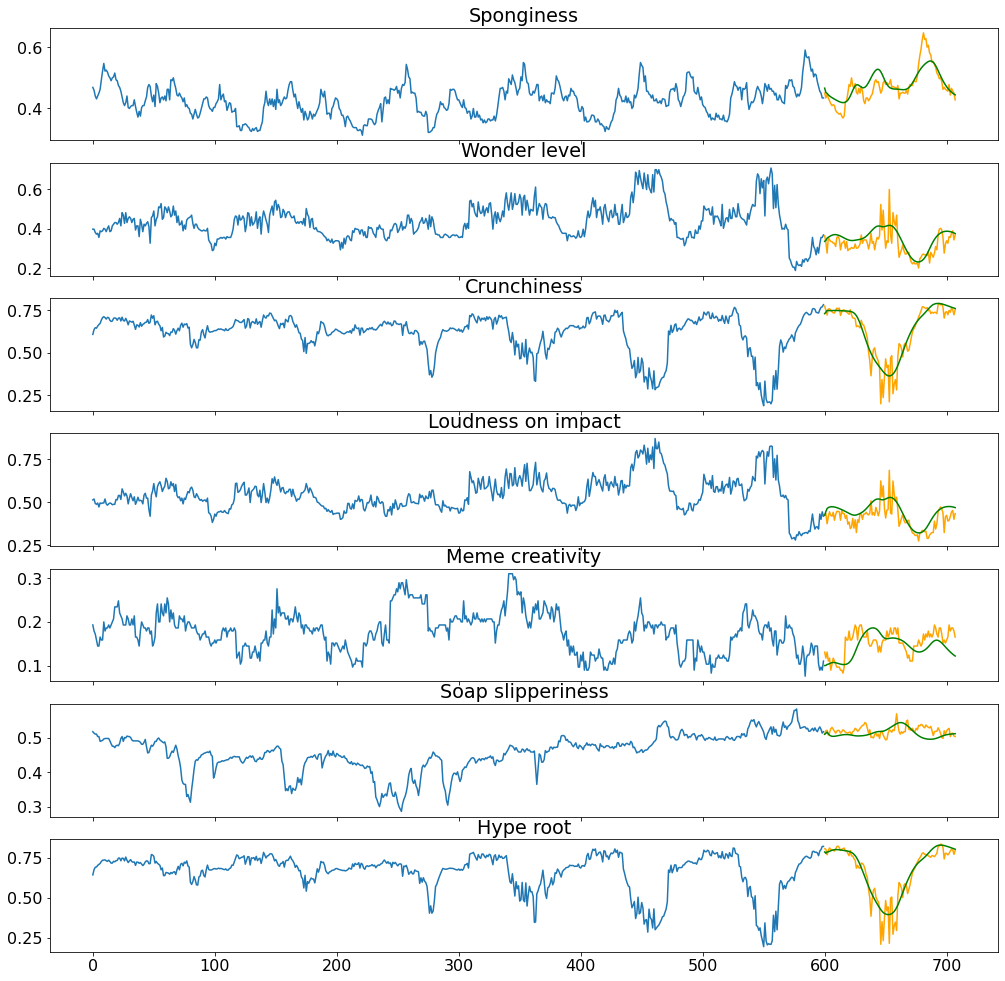

In [40]:
inspect_multivariate_prediction(X, Y, predictions, dataset.columns, telescope)

In [41]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(Y[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [42]:
reg_telescope = 864
X_test_reg, y_test_reg  = chunk(normalized_ds, window, reg_telescope, stride)
X_test_reg = X_test_reg[-10:]
y_test_reg = y_test_reg[-10:]
X_test_reg.shape, y_test_reg.shape

((10, 600, 7), (10, 864, 7))

In [43]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [44]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0050066155>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.051722895>)

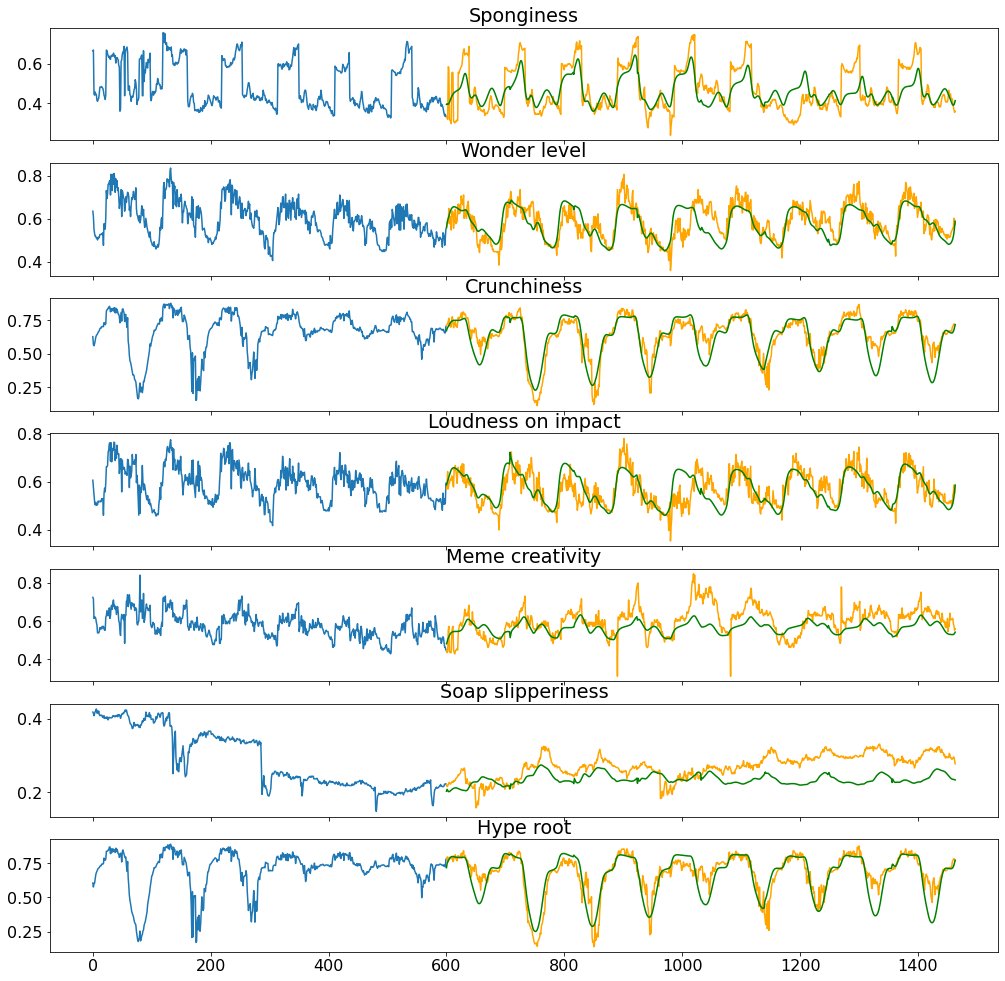

In [45]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, dataset.columns, reg_telescope)